In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Veri estini yükleme
data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')
print(data.head())
print(data.info())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


Burada gerekli kütüphaneler yükler ve seçtiğimiz fer2013 adlı veri setini okur.

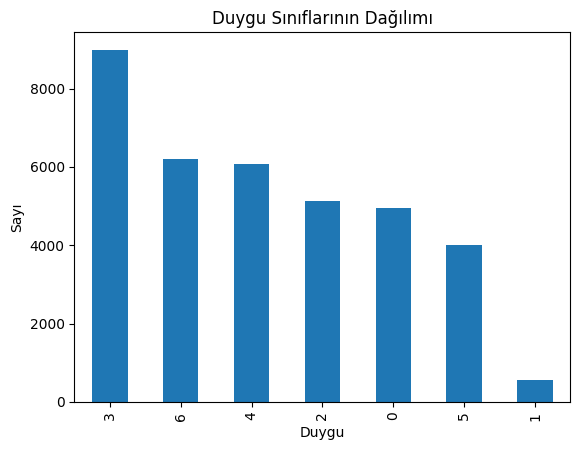

In [3]:
# Sınıf dağılımını görselleştirme
emotion_counts = data['emotion'].value_counts()
emotion_counts.plot(kind='bar')
plt.title('Duygu Sınıflarının Dağılımı')
plt.xlabel('Duygu')
plt.ylabel('Sayı')
plt.show()

Veri setindeki duygu sınıflarının örneklerinni sayarak bunu bir görsel grafiğe dönüştürür.

In [4]:
# 'pixels' sütunu boşluklarla ayrılmış piksel değerlerini içeriyorsa
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), 'float32'))

# Görüntüleri yeniden şekillendirme ve normalleştirme
X = np.stack(data['pixels'].values).reshape(-1, 48, 48, 1) / 255.0

# Etiketleri 'one-hot encoding' ile dönüştürün
y = pd.get_dummies(data['emotion']).values

Burada ham veriyi kendi okuyabileceği formata dönüştürür.

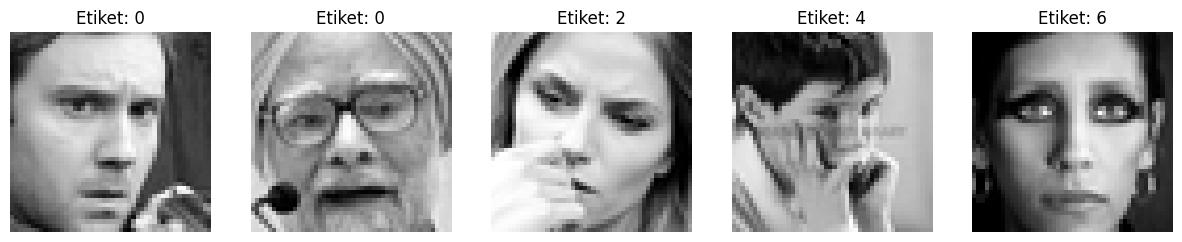

In [5]:
# Birkaç örnek görüntüyü gösterme
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(48, 48), cmap='gray')
    ax.set_title(f"Etiket: {np.argmax(y[i])}")
    ax.axis('off')
plt.show()

Bu verilen görsellerin modele uygun olup olmadığını gösteren görsel bir testtir.

In [6]:
from sklearn.model_selection import train_test_split

# Veriyi önce eğitim ve geçici setlere ayırın
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Geçici seti doğrulama ve test setlerine ayırın
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Eğitim Seti Boyutu: {len(X_train)}")
print(f"Doğrulama Seti Boyutu: {len(X_val)}")
print(f"Test Seti Boyutu: {len(X_test)}")

Eğitim Seti Boyutu: 25120
Doğrulama Seti Boyutu: 5383
Test Seti Boyutu: 5384


Burada modelin dürüst ve güvenilir bir şekilde değerlendirilmesini sağlamak için gerekli olan üç bağımsız veri seti oluşturulur.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dönüşümleri içeren veri çoğaltma oluşturun
datagen = ImageDataGenerator(
    rotation_range=15,          # Görüntüleri 15 dereceye kadar döndür
    width_shift_range=0.1,      # Genişlik yönünde kaydır
    height_shift_range=0.1,     # Yükseklik yönünde kaydır
    shear_range=0.1,            # Kesme dönüşümleri uygula
    zoom_range=0.1,             # Yakınlaştırma/uzaklaştırma yap
    horizontal_flip=True,       # Yatay olarak çevir
    fill_mode='nearest'         # Dönüşüm sonrası boş pikselleri doldur
)

# Oluşturulan veri çoğaltıcıyı eğitim verilerine uygulayın
datagen.fit(X_train)

2025-09-26 17:25:37.154413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758907537.180433    1111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758907537.188426    1111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Burada elindeki veriyi çeşitlendirerek daha çeşitli görsele ulaşmış olur ve modelin ezber yapmasının önüne geçer.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

# Veri ön işleme adımlarını çalıştırmayı unutmayın, bu yüzden y_train değişkeni tanımlı olur
# (Örn: X_train, y_train = ...)

# Modeli oluşturma
model = Sequential()

# İlk Evrişim Katmanı
# Girdi boyutunu ilk katmanda belirleyin
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# İkinci Evrişim Katmanı
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Üçüncü Evrişim Katmanı
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Düzleştirme Katmanı (Flatten)
model.add(Flatten())

# Tam Bağlantılı (Dense) Katmanlar
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax')) # Çıkış katmanı

# Modelin özetini gösterin
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-26 17:25:40.482464: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Burada CNN modeli inşa edilir.

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Burada CNN modeline nasıl öğreneceğini, öğrenmede neyi hedefleyeceğini ve başarısını nasıl ölçeceğini söyler.

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=50, 
                    validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - accuracy: 0.2324 - loss: 1.8315 - val_accuracy: 0.2571 - val_loss: 1.7642
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.2649 - loss: 1.7746 - val_accuracy: 0.3257 - val_loss: 1.6708
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - accuracy: 0.3025 - loss: 1.7241 - val_accuracy: 0.3797 - val_loss: 1.5787
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.3398 - loss: 1.6577 - val_accuracy: 0.4269 - val_loss: 1.4729
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.3728 - loss: 1.5947 - val_accuracy: 0.4336 - val_loss: 1.4635
Epoch 6/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.4003 - loss: 1.5490 - val_accuracy: 0.4661 - val_loss: 1.3774
Epoch 7/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.4171 - loss: 1.5013 - val_accuracy: 0.4828 - val_loss: 1.3755
Epoch 8/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.4282 - loss: 1

Burada model eğitilir.

In [ ]:
import matplotlib.pyplot as plt

# Doğruluk (Accuracy) grafiği
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epok')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper left')
plt.show()

# Kayıp (Loss) grafiği
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epok')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper left')
plt.show()

Accuracy ve Loss grafikleri oluşturulur.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test seti üzerinde tahmin yapın
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix'i oluşturun ve görselleştirin
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kızgın', 'İğrenme', 'Korku', 'Mutlu', 'Üzgün', 'Şaşkın', 'Tarafsız'],
            yticklabels=['Kızgın', 'İğrenme', 'Korku', 'Mutlu', 'Üzgün', 'Şaşkın', 'Tarafsız'])
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

# Classification Report'u yazdırın
print(classification_report(y_true_classes, y_pred_classes))

Modelin başarısını ölçer.

In [ ]:
model.save('Duygu_Modeli.h5')

Modeli kaydeder.